### Analysis of Texas data

This notebook runs the following analyses:

- filter down data to just relevant penal codes
    - exports relevant penal code for closer examination
- summarize data:
    - by race
    - by home address
- find profiles of "average" package theft defendants 
- summarize sentencing (where data is available)


In [1]:
import datetime
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

#### Load data, make overviews and loade penal code data for filtering
- load crime data
    - Harris county (Houston): `Data - Vo.xlsx`
    - Bexar county (San Antonio): `R007531_-__RITM0071593_20150101_to_20210809.xlsx`
    - Travis county (Austin): `DataExport.xlsx` (felony), `LamVo_Criminal_Export_08232021.xlsx` (misdemeanor)
    - Dallas county (Dallas): `PIA_243697_dataset.xlsx`
- format date columns as `datetime64[ns]` 
- load penal codes

In [2]:
# renaming of all columns:
houston_columns = {
    "cas": "case_id",
    "curr_off":"Offense Code",
    "curr_off_lit":"Literal",
    "def_rac": "race",
    "def_sex": "sex",
    "def_citizen": "citizen",
    "fda":"offense_or_input_date", 
    "def_stnam": "street_name",
}
sanantonio_columns = {
    "CASE_CAUSE_NBR": "case_id",
    "OFFENSE_CODE":"Offense Code",
    "OFFENSE_DESC":"Literal",
    "RACE": "race",
    "SEX": "sex",
    "CITIZENSHIP": "citizen",
    "OFFENSE_DATE":"offense_or_input_date", 
    "ADDR_STREET": "street_name",
}

austin_misdemeanor_columns = {
    "cs_id": "case_id",
    "charge":"Offense Code",
    "charge_desc":"Literal",
    "filing_dt":"offense_or_input_date", 
}

austin_felony_columns = {
    "cs_num_txt": "case_id",
    "charge":"Offense Code",
    "charge_desc":"Literal",
    "race": "race",
    "gender": "sex",
    "ethnicity":"latinx",
    "filing_dt": "offense_or_input_date",
    "addrss_ln_1": "street_name",
}

dallas_columns = {
    "case no.":"case_id", 
    "offensedescription": "Literal",
    "race": "race",
    "sex": "sex",
    "ethnicity":"latinx",
    "US Citizen":"citizen",
    "Citation":"Citation",
    "Offense Date":"offense_or_input_date",
    "PrimaryAddress":"street_name"
}

In [3]:
%%time
houston_data = pd.read_excel(
        "../data/harris_county/DATA - Vo.xlsx",
        dtype = {
            "curr_off":"str",
            "curr_off_lit":"str",
            "fda": "str",
            "dispdt": "str",
            "def_dob":"str",
            "nda":"str"
        },
        parse_dates = ["fda"]
    ).rename(
    columns = houston_columns
)

sanantonio_data = pd.read_excel(
    "../data/bexar_county/R007531_-__RITM0071593_20150101_to_20210809.xlsx",
    dtype = {
        "CASE_CAUSE_NBR":"str",
        "OFFENSE_CODE": "str",
        "HEARING_DATE": "str",
        "DISPOSITION_CODE":"str",
        "TRIAL_DATE":"str"
    }
).rename(
    columns = sanantonio_columns
)

austin_data_misdemeanor = pd.read_excel(
    "../data/travis_county/LamVo_Criminal_Export_08232021.xlsx",
    dtype = {
        "charge":"str",
        "charge_desc": "str",

    },
    parse_dates=["filing_dt"]
).rename(
    columns = austin_misdemeanor_columns
)

austin_data_felony = pd.read_excel(
    "../data/travis_county/DataExport_sentence_race_eth_gen.xlsx",
    dtype = {
        "charge":"str",
        "charge_desc": "str",
        "dispdt": "str",
    },
    parse_dates=["filing_dt"]
).rename(
    columns = austin_felony_columns
)

dallas_data = pd.read_excel(
    "../data/dallas_county/PIA_243697_dataset.xlsx",

    dtype = {
        "ZipCode":"str",
        "charge_desc": "str",
        "book-in no.": "str",
    },
    parse_dates=["Offense Date", "arrest date", "dob"]
).rename(
    columns = dallas_columns
)

CPU times: user 51.2 s, sys: 1.58 s, total: 52.8 s
Wall time: 1min 57s


In [4]:
dallas_data.head()

,case_id,offense_or_input_date,street_name,City,ZipCode,Literal,Citation,disposition,Court date,arrest date,book-in no.,race,latinx,sex,dob,citizen,arresting agency
0,F1210128H,2012-08-26,NaN,CARROLLTON,75010,"PROBATION VIOLATION - THEFT <$1,500 2/MORE PR...",31.03(e)(4)(D),Served In Jail,2014-11-20 00:00:00,2015-01-01,15000307,Black,Non Hispanic,Male,1973-01-07,Yes,Irving Police
1,F1472089L,2014-10-23,NaN,DALLAS,75217,THEFT FROM PERSON,31.03(e)(4)(B),Served In Jail,Null,2015-01-01,15000157,Black,Non Hispanic,Male,1984-11-10,Yes,Dallas Police
2,F1513640,2015-01-01,NaN,DALLAS,75227,THEFT OF FIREARM,31.03(e)(4)(C),Null,Null,2015-01-01,15000224,Black,Non Hispanic,Male,1993-01-16,Yes,CEDAR HILL PD
3,F1513641,2015-01-01,NaN,DALLAS,75227,THEFT OF FIREARM,31.03(e)(4)(C),Null,Null,2015-01-01,15000224,Black,Non Hispanic,Male,1993-01-16,Yes,CEDAR HILL PD
4,F1532755,2015-01-01,NaN,IRVING,00000,THEFT FROM PERSON,31.03(e)(4)(B),Null,Null,2015-01-01,15000325,White,Hispanic,Male,1972-07-15,No,Irving Police


In [5]:
dallas_data.columns

Index(['case_id', 'offense_or_input_date', 'street_name', 'City', 'ZipCode',
       'Literal', 'Citation', 'disposition', 'Court date', 'arrest date',
       'book-in no.', 'race', 'latinx', 'sex', 'dob', 'citizen',
       'arresting agency'],
      dtype='object')

In [6]:
print(
    "Houston ", len(houston_data),
    "San Antonio: ", len(sanantonio_data),
    "Austin misdemeanor ", len(austin_data_misdemeanor),
    "Austin felony: ", len(austin_data_felony),
    "Dallas:", len(dallas_data)
)

Houston  38742 San Antonio:  14964 Austin misdemeanor  5016 Austin felony:  4301 Dallas: 51282


In [7]:
houston_data.T

,0,1,2,3,4,5,6,7,8,9,...,38732,38733,38734,38735,38736,38737,38738,38739,38740,38741
cdi,2,2,2,2,2,2,2,2,2,2,...,3,3,3,3,3,3,3,3,3,3
case_id,201091901010,202490601010,203438401010,204569601010,204570201010,204570301010,204571401010,204572001010,204572001010,204572901010,...,173559601010,173560501010,173565301010,173567501010,173567901010,173575801010,173578101010,173584101010,173592901010,173593001010
offense_or_input_date,2015-02-20,2015-05-09,2015-07-01,2015-09-02,2015-09-02,2015-09-02,2015-09-03,2015-09-03,2015-09-03,2015-09-03,...,2021-08-14,2021-08-14,2021-08-14,2021-08-15,2021-08-15,2021-08-15,2021-08-16,2021-08-16,2021-08-17,2021-08-17
ins,MIN,MIN,MIN,MIN,MIN,MIN,MIN,MIN,MIN,MIN,...,COM,COM,COM,COM,COM,COM,COM,COM,COM,COM
cad,DISP,DISP,DISP,DISM,DISM,DISM,,DISP,DISP,DISP,...,,,,,,,,,,
crt,3,6,5,15,5,5,1,10,10,1,...,248,263,337,208,180,179,180,351,338,338
cst,C,C,C,D,D,D,Z,C,C,C,...,A,I,A,A,A,A,A,A,A,A
dst,D,D,D,D,D,D,N,D,D,D,...,J,J,B,J,B,B,B,J,J,J
bam,10000,5000,1000,500,500,1500,4000,3500,3500,1000,...,7500,25000,500,5000,2500,2500,2500,5000,10000,10000
Offense Code,239100,239100,239100,239100,239100,239100,239100,239100,239100,239100,...,231604,230152,230152,230153,230152,230152,230152,230152,230152,230152


In [8]:
sanantonio_data.T

,0,1,2,3,4,5,6,7,8,9,...,14954,14955,14956,14957,14958,14959,14960,14961,14962,14963
case_id,493940,490214,487204,497363,490089,496777,494417,494405,497205,486663,...,668832,666628,666773,2021CR7370W,666840,666846,666823,667023,667032,667013
offense_or_input_date,20121120,20130418,20130613,20130809,20130924,20131014,20131017,20131019,20131027,20131104,...,20210802,20210802,20210804,20210805,20210805,20210805,20210805,20210808,20210808,20210808
Offense Code,239976,239976,239976,239976,239976,239976,239976,239976,239976,239976,...,230249,230249,230249,240405,230249,230249,230249,230249,230249,230249
DISPOSITION_CODE,682,NaN,682,682,682,641,641,682,682,682,...,NaN,NaN,NaN,641,NaN,NaN,NaN,NaN,NaN,NaN
DISPOSITION_DESC,DSMD-REST PD/FULL,NaN,DSMD-REST PD/FULL,DSMD-REST PD/FULL,DSMD-REST PD/FULL,NOLO CT-GUILTY,NOLO CT-GUILTY,DSMD-REST PD/FULL,DSMD-REST PD/FULL,DSMD-REST PD/FULL,...,NaN,NaN,NaN,NOLO CT-GUILTY,NaN,NaN,NaN,NaN,NaN,NaN
Literal,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,THEFT $20-$500 - CHECK,...,THEFT $100 TO < $750,THEFT $100 TO < $750,THEFT $100 TO < $750,"THEFT $30,000 TO < $150,000 VE",THEFT $100 TO < $750,THEFT $100 TO < $750,THEFT $100 TO < $750,THEFT $100 TO < $750,THEFT $100 TO < $750,THEFT $100 TO < $750
HEARING_DATE,20161006,NaN,NaN,NaN,NaN,20170726,20160920,NaN,NaN,NaN,...,NaN,20211007,NaN,20210816,20220203,20220112,20211214,NaN,20211027,NaN
TRIAL_DATE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20210816,NaN,NaN,NaN,NaN,NaN,NaN
race,W,B,W,B,L,L,L,B,L,B,...,W,L,L,B,W,W,B,W,W,W
sex,F,M,M,M,M,F,F,F,F,F,...,F,F,M,M,M,M,F,F,F,F


In [9]:
austin_data_misdemeanor.T

,0,1,2,3,4,5,6,7,8,9,...,5006,5007,5008,5009,5010,5011,5012,5013,5014,5015
case_id,1192477,1197037,1197270,1202023,1202834,1202843,1203119,1203144,1203201,1203292,...,1399629,1399649,1399689,1400003,1400194,1400259,1400431,1400528,1400581,1400741
cause_nbr,C-1-CR-15-300217,C-1-CR-15-300260,C-1-CR-15-403921,C-1-CR-15-501171,C-1-CR-15-213256,C-1-CR-15-213266,C-1-CR-15-213309,C-1-CR-15-213334,C-1-CR-15-213454,C-1-CR-15-213553,...,C-1-CR-21-500801,C-1-CR-21-500806,C-1-CR-21-206064,C-1-CR-21-500829,C-1-CR-21-206370,C-1-CR-21-500850,C-1-CR-21-500901,C-1-CR-21-206527,C-1-CR-21-206544,C-1-CR-20-400212
case_type,HTC,HTC,FRL,WRA,WLA,WLA,WLA,WLA,WLA,WLA,...,WRA,WRA,WLA,WRA,WLA,WRA,WRA,WLA,WLA,FRL
case_type_description,CR HOT CHECKS,CR HOT CHECKS,CR FIELD RELEASE,CR WARRANT ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,...,CR WARRANT ARREST,CR WARRANT ARREST,CR WARRANTLESS ARREST,CR WARRANT ARREST,CR WARRANTLESS ARREST,CR WARRANT ARREST,CR WARRANT ARREST,CR WARRANTLESS ARREST,CR WARRANTLESS ARREST,CR FIELD RELEASE
case_status,DS,DS,PO,FD,DS,DP,FD,FD,FD,FD,...,AC,WA,AC,WA,AC,WA,WA,AC,AC,CI
judge,CC7,CC5,CC7,CC5,CC9,CC6,CC5,CC7,CC6,CC3,...,CC3,CC5,CC9,CC3,CC8,CC5,CC3,CC6,CC8,CC8
Offense Code,23990191,23990191,23990191,23990191,23990191,23990191,23990191,23990191,23990192,23990191,...,23990191,23990191,23990191,23990191,23990192,23990191,23990191,23990191,23990191,23990191
Literal,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP <$100 W/PREV CONVIC ...,THEFT PROP >=$100<$750 ...,...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP <$100 W/PREV CONVIC ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...,THEFT PROP >=$100<$750 ...
class,B,B,B,B,B,B,B,B,B,B,...,B,B,B,B,B,B,B,B,B,B
offense_or_input_date,2015-06-12 00:00:00,2015-07-14 00:00:00,2015-07-15 00:00:00,2015-08-27 00:00:00,2015-09-04 00:00:00,2015-09-04 00:00:00,2015-09-08 00:00:00,2015-09-08 00:00:00,2015-09-08 00:00:00,2015-09-09 00:00:00,...,2021-07-16 00:00:00,2021-07-16 00:00:00,2021-07-23 00:00:00,2021-07-22 00:00:00,2021-08-02 00:00:00,2021-07-23 00:00:00,2021-08-04 00:00:00,2021-08-06 00:00:00,2021-08-09 00:00:00,2021-08-05 00:00:00


In [10]:
austin_data_felony.T

,0,1,2,3,4,5,6,7,8,9,...,4291,4292,4293,4294,4295,4296,4297,4298,4299,4300
case_id,D-1-DC-14-207466,D-1-DC-15-200008,D-1-DC-15-100001,D-1-DC-15-200023,D-1-DC-15-200039,D-1-DC-15-200039,D-1-DC-15-300134,D-1-DC-15-200620,D-1-DC-15-600022,D-1-DC-15-300378,...,D-1-DC-21-204765,D-1-DC-21-204776,D-1-DC-21-204777,D-1-DC-21-204731,D-1-DC-21-204732,D-1-DC-21-301629,D-1-DC-21-204881,D-1-DC-21-204927,D-1-DC-21-500232,D-1-DC-21-500232
offense_or_input_date,2015-01-02 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00,2015-01-05 00:00:00,2015-01-05 00:00:00,2015-01-05 00:00:00,2015-01-15 00:00:00,2015-02-02 00:00:00,2015-02-10 00:00:00,2015-02-12 00:00:00,...,2021-08-30 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2021-09-03 00:00:00,2021-09-07 00:00:00,2021-09-07 00:00:00,2021-09-07 00:00:00,2021-09-07 00:00:00
cs_sts_desc,TCJ SENTENCE,SJF SENTENCE,TCJ SENTENCE,SJF SENTENCE,TCJ SENTENCE,TCJ SENTENCE,DISMISSED,TCJ SENTENCE,SJF SENTENCE,SJF SENTENCE,...,TCJ SENTENCE,PRE INDICTMENT,NO CHRGES FILED,PRE INDICTMENT,PRE INDICTMENT,WARRANT CASE,TCJ SENTENCE,TCJ SENTENCE,WARRANT CASE,WARRANT CASE
race,White,Black,Black,Black,Black,Black,White,White,Black,Black,...,Black,Black,Black,White,White,NaN,White,White,Black,Unknown
latinx,NaN,NaN,NaN,NaN,NaN,NaN,Hispanic,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hispanic,NaN,NaN
sex,Male,Male,Male,Female,Female,Female,Male,Male,Male,Male,...,Male,Male,Male,Male,Male,NaN,Male,Male,Male,Male
prty_typ,DF,DF,DF,DF,DF,DF,DF,DF,DF,DF,...,DF,DF,DF,DF,DF,DF,DF,DF,DF,DF
street_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TRANSIENT,NaN,NaN,NaN,NaN,NaN,TRANSIENT,NaN,NaN,NaN
addrss_ln_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,...
city_desc,AUSTIN,AUSTIN,NaN,AUSTIN,AUSTIN,AUSTIN,AUSTIN,FORT WORTH,NaN,ROUND ROCK,...,AUSTIN,TAYLOR,LAREDO,AUSTIN,AUSTIN,NaN,AUSTIN,AUSTIN,AUSTIN,AUSTIN


In [11]:
dallas_data

,case_id,offense_or_input_date,street_name,City,ZipCode,Literal,Citation,disposition,Court date,arrest date,book-in no.,race,latinx,sex,dob,citizen,arresting agency
0,F1210128H,2012-08-26,NaN,CARROLLTON,75010,"PROBATION VIOLATION - THEFT <$1,500 2/MORE PR...",31.03(e)(4)(D),Served In Jail,2014-11-20 00:00:00,2015-01-01,15000307,Black,Non Hispanic,Male,1973-01-07,Yes,Irving Police
1,F1472089L,2014-10-23,NaN,DALLAS,75217,THEFT FROM PERSON,31.03(e)(4)(B),Served In Jail,Null,2015-01-01,15000157,Black,Non Hispanic,Male,1984-11-10,Yes,Dallas Police
2,F1513640,2015-01-01,NaN,DALLAS,75227,THEFT OF FIREARM,31.03(e)(4)(C),Null,Null,2015-01-01,15000224,Black,Non Hispanic,Male,1993-01-16,Yes,CEDAR HILL PD
3,F1513641,2015-01-01,NaN,DALLAS,75227,THEFT OF FIREARM,31.03(e)(4)(C),Null,Null,2015-01-01,15000224,Black,Non Hispanic,Male,1993-01-16,Yes,CEDAR HILL PD
4,F1532755,2015-01-01,NaN,IRVING,00000,THEFT FROM PERSON,31.03(e)(4)(B),Null,Null,2015-01-01,15000325,White,Hispanic,Male,1972-07-15,No,Irving Police
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51277,F1925444P,2019-08-28,NaN,GARLAND,75040,PROBATION VIOLATION - THEFT OF FIREARM,31.03(e)(4)(C),Served In Jail,Null,2020-12-31,20045723,White,Hispanic,Male,2001-02-06,Yes,Dallas Police
51278,F2024849,2020-07-19,NaN,SEAGOVILLE,75253,"BENCH WARRANT - THEFT PROP >=$2,500<$30K",31.03(e)(4)(A),In Jail,Null,2020-12-31,20045752,White,Non Hispanic,Male,1969-05-11,Yes,Dallas County Sheriff
51279,F2032552,2020-12-27,NaN,HUTCHINS,75141,THEFT PROP >=$30K<$150K,31.03(e)(5),Returned,Null,2020-12-31,20045775,White,Hispanic,Male,1994-11-01,Yes,Dallas Police
51280,m1912645k,2019-09-09,NaN,DALLAS,75212,INSUFFICIENT BOND - THEFT PROP >=$100<$750,31.03(e)(2)(A),Null,Null,2020-12-31,20045729,White,Hispanic,Male,1997-07-07,Yes,Dallas County Sheriff


#### Turn relevant columns into dates

In [12]:
column_names = ["def_dob", "dispdt","nda"]

def makeDateString(x):
    if x != None and len(str(x)) > 7 :
        return str(x)[:4]+"-"+ str(x)[4:6] +"-"+ str(x)[6:]
    else:
        return x

for column_name in column_names: 
    houston_data[column_name +"_dt"] = houston_data[column_name].apply(makeDateString).astype("datetime64[ns]")

houston_data["offense_or_input_date"] = houston_data["offense_or_input_date"].astype("datetime64[ns]")
houston_data.head()

,cdi,case_id,offense_or_input_date,ins,cad,crt,cst,dst,bam,Offense Code,...,comp_nam,comp_agency,off_rpt_num,dispdt,disposition,sentence,citizen,def_dob_dt,dispdt_dt,nda_dt
0,2,201091901010,2015-02-20,MIN,DISP,3,C,D,10000,239100,...,"ALLEN, J L",HOUSTON POLICE DEPARTMENT,11779215,20151113,CONVICTION-PLEA OF GUILTY,30 DAYS HCJ,Y,1986-07-08,2015-11-13,2015-11-13
1,2,202490601010,2015-05-09,MIN,DISP,6,C,D,5000,239100,...,"GOLDEN, JERMEY",HUMBLE PD,15002485,20151116,CONVICTION-PLEA OF GUILTY,6 DAYS HCJ,Y,1993-02-13,2015-11-16,2015-11-16
2,2,203438401010,2015-07-01,MIN,DISP,5,C,D,1000,239100,...,"TORRES, S E",HOUSTON POLICE DEPARTMENT,84605215,20151002,CONVICTION-PLEA OF GUILTY,2 DAYS HCJ,Y,1978-04-07,2015-10-02,2015-10-02
3,2,204569601010,2015-09-02,MIN,DISM,15,D,D,500,239100,...,"SALAZAR, JUAN",PASADENA POLICE DEPARTMENT,201520791,20160620,DISMISSED,NaN,Y,1997-11-07,2016-06-20,2016-06-20
4,2,204570201010,2015-09-02,MIN,DISM,5,D,D,500,239100,...,"COOPER, CHRISTOPHER",SHERIFF'S DEPARTMENT HARRIS COUNTY,HC15136307,20160531,DISMISSED,NaN,Y,1990-12-22,2016-05-31,2016-05-31


In [13]:
houston_data.dtypes

cdi                               int64
case_id                           int64
offense_or_input_date    datetime64[ns]
ins                              object
cad                              object
crt                               int64
cst                              object
dst                              object
bam                              object
Offense Code                     object
Literal                          object
curr_l_d                         object
com_off                         float64
com_off_lit                      object
com_l_d                          object
gj_off                          float64
gj_off_lit                       object
gj_l_d                           object
nda                              object
cnc                              object
rea                              object
def_spn                           int64
race                             object
sex                              object
def_dob                          object


## Overall analyses for all cities

- pare down data to necessary categories, merge them and add `city` column
- filter data to just package theft and export it
- summarize data:
    - by race
    - by home address
- find profiles of "average" package theft defendants 
- summarize sentencing


### Filter data to just package theft and export it. 
Source for penal codes:
- package theft codes: https://www.dps.texas.gov/section/crime-records/appendix-k-offense-codes
- shoplofting codes: https://statutes.capitol.texas.gov/Docs/PE/htm/PE.31.htm, https://www.dps.texas.gov/administration/crime_records/docs/cjis/offenseCodesStatuteOrder.rtf

In [14]:
penal_codes_dict = pd.read_csv(
    "../data/requested_codes.csv",
    dtype = {
        "Offense Code":"str"
    }
)
penal_codes_dict.head()

,Offense Code,Literal,Citation,Statute,L/D,Bill #/Reason,category_degree,category,comment
0,23160001,THEFT-MAIL <=10 ADDRESSES,31.20(c)(1),PC,MA,HB37,misdemeanor,package_theft,from here update
1,23160002,THEFT-MAIL =10<30 ADDRESSES,31.20(c)(2),PC,FS,HB37,felony,package_theft,NaN
2,23160003,THEFT-MAIL =>30 ADDRESSES,31.20(c)(3),PC,F3,HB37,felony,package_theft,NaN
3,23160004,THEFT-MAIL ID INFO <=10 ADDRESSES IAT,31.20(d)(1),PC,FS,HB37,felony,package_theft,NaN
4,23160005,THEFT-MAIL ID INFO =10<20 ADDRESSES IAT,31.20(d)(2),PC,F3,HB37,felony,package_theft,NaN


In [15]:

houston_data_df = (
    pd.merge(
        houston_data,
        penal_codes_dict[["Offense Code", "Literal", "category_degree", "category"]],
        on=["Literal"],
        how="left"
    )
    .dropna(
        subset=["category"]
    )
)

houston_data_df = houston_data_df[houston_data_df["category"] == "package_theft"]

dallas_data_df = (
    pd.merge(
        dallas_data,
        penal_codes_dict[["Citation","Offense Code", "Literal", "category_degree", "category"]],
        on=["Citation"],
        how="left"
    ).dropna(
        subset=["category"]
    )
    
).rename(
    columns={"Literal_y": "Literal"}
)

sanantonio_data_df = (
    sanantonio_data[sanantonio_data["Literal"].apply(lambda x: "mail" in x.lower())]
)


austin_data_felony_df = (
    pd.merge(
        austin_data_felony,
        penal_codes_dict[["Offense Code", "Literal", "category_degree", "category"]],
        on=["Literal"],
        how="left"
    )
    .dropna(
        subset=["category"]
    )
)

austin_data_felony_df=austin_data_felony_df[austin_data_felony_df["category"] == "package_theft"]


austin_data_misdemeanor_df = (
    austin_data_misdemeanor[austin_data_misdemeanor["Literal"].apply(lambda x: "mail" in x.lower())]
)

In [16]:
dallas_data_df.head()

,case_id,offense_or_input_date,street_name,City,ZipCode,Literal_x,Citation,disposition,Court date,arrest date,...,race,latinx,sex,dob,citizen,arresting agency,Offense Code,Literal,category_degree,category
0,F1210128H,2012-08-26,NaN,CARROLLTON,75010,"PROBATION VIOLATION - THEFT <$1,500 2/MORE PR...",31.03(e)(4)(D),Served In Jail,2014-11-20 00:00:00,2015-01-01,...,Black,Non Hispanic,Male,1973-01-07,Yes,Irving Police,23990196,"THEFT PROP <$2,500 2/MORE PREV CONV",felony,other
1,F1472089L,2014-10-23,NaN,DALLAS,75217,THEFT FROM PERSON,31.03(e)(4)(B),Served In Jail,Null,2015-01-01,...,Black,Non Hispanic,Male,1984-11-10,Yes,Dallas Police,23990132,THEFT FROM PERSON,felony,other
4,F1532755,2015-01-01,NaN,IRVING,00000,THEFT FROM PERSON,31.03(e)(4)(B),Null,Null,2015-01-01,...,White,Hispanic,Male,1972-07-15,No,Irving Police,23990132,THEFT FROM PERSON,felony,other
5,F1532756,2015-01-01,NaN,IRVING,75061,THEFT FROM PERSON,31.03(e)(4)(B),Null,Null,2015-01-01,...,White,Hispanic,Male,1987-11-23,No,Irving Police,23990132,THEFT FROM PERSON,felony,other
7,f1551010,2015-01-01,NaN,UNK,00000,THEFT FROM PERSON,31.03(e)(4)(B),Null,Null,2015-01-01,...,White,Non Hispanic,Male,1976-02-14,Yes,Dallas Police,23990132,THEFT FROM PERSON,felony,other


In [17]:
print(
    len(houston_data_df),houston_data_df.columns, 
    len(sanantonio_data_df), sanantonio_data_df.columns,
    len(austin_data_felony_df), austin_data_felony_df.columns,
    len(austin_data_misdemeanor_df), austin_data_misdemeanor_df.columns,
)

141 Index(['cdi', 'case_id', 'offense_or_input_date', 'ins', 'cad', 'crt', 'cst',
       'dst', 'bam', 'Offense Code_x', 'Literal', 'curr_l_d', 'com_off',
       'com_off_lit', 'com_l_d', 'gj_off', 'gj_off_lit', 'gj_l_d', 'nda',
       'cnc', 'rea', 'def_spn', 'race', 'sex', 'def_dob', 'def_stnum',
       'street_name', 'def_cty', 'def_st', 'def_zip', 'aty_nam', 'aty_spn',
       'aty_coc', 'aty_coc_lit', 'comp_nam', 'comp_agency', 'off_rpt_num',
       'dispdt', 'disposition', 'sentence', 'citizen', 'def_dob_dt',
       'dispdt_dt', 'nda_dt', 'Offense Code_y', 'category_degree', 'category'],
      dtype='object') 138 Index(['case_id', 'offense_or_input_date', 'Offense Code', 'DISPOSITION_CODE',
       'DISPOSITION_DESC', 'Literal', 'HEARING_DATE', 'TRIAL_DATE', 'race',
       'sex', 'citizen', 'ADDR_HOUSE_NBR', 'street_name', 'ADDR_CITY',
       'ADDR_STATE'],
      dtype='object') 11 Index(['case_id', 'offense_or_input_date', 'cs_sts_desc', 'race', 'latinx',
       'sex', 'prty_typ',

In [18]:
sanantonio_data_df["Literal"].value_counts()

THEFT MAIL <=10 ADDRESSES         76
THEFT MAIL =10<30 ADDRESSES       36
THEFT MAIL =>30 ADDRESSES         12
THEFT MAIL ID INFO <=10 ADDRES     8
THEFT MAIL ID INFO =20<50 ADDR     2
THEFT MAIL ID INFO =>50 ADDRES     2
ATT THEFT MAIL =10<30 ADDRESSE     2
Name: Literal, dtype: int64

In [19]:
austin_data_felony_df["category"].value_counts()

package_theft    11
Name: category, dtype: int64

In [20]:
dallas_data_df = dallas_data_df[dallas_data_df["category"] == "package_theft"]
dallas_data_df.head()

,case_id,offense_or_input_date,street_name,City,ZipCode,Literal_x,Citation,disposition,Court date,arrest date,...,race,latinx,sex,dob,citizen,arresting agency,Offense Code,Literal,category_degree,category
228,M2022408B,2020-04-21,NaN,MESQUITE,75150,INSUFFICIENT BOND - THEFT-MAIL <=10 ADDRESSES,31.20(c)(1),Null,Null,2021-01-02,...,White,Non Hispanic,Male,1981-07-21,Yes,Dallas Police,23160001,THEFT-MAIL <=10 ADDRESSES,misdemeanor,package_theft
1490,F2151288,2021-01-10,NaN,THE COLONY,75056,THEFT-MAIL =10<30 ADDRESSES,31.20(c)(2),Returned,Null,2021-01-10,...,White,Non Hispanic,Male,1989-07-17,Yes,Dallas Police,23160002,THEFT-MAIL =10<30 ADDRESSES,felony,package_theft
1492,M2022234K,2020-01-07,NaN,DALLAS,75233,THEFT-MAIL <=10 ADDRESSES,31.20(c)(1),Returned,Null,2021-01-10,...,Black,Non Hispanic,Male,1966-11-06,Yes,Dallas Police,23160001,THEFT-MAIL <=10 ADDRESSES,misdemeanor,package_theft
2941,M2145132E,2021-01-19,NaN,RICHARDSON,75080,THEFT-MAIL <=10 ADDRESSES,31.20(c)(1),Served On Bond,Null,2021-01-19,...,White,Non Hispanic,Female,1988-02-01,Yes,Richardson Police,23160001,THEFT-MAIL <=10 ADDRESSES,misdemeanor,package_theft
4121,M2132896K,2021-01-21,HOMELESS,IRVING,00000,THEFT-MAIL <=10 ADDRESSES,31.20(c)(1),Served On Bond,Null,2021-01-26,...,White,Unknown,Male,1985-02-02,No,Irving Police,23160001,THEFT-MAIL <=10 ADDRESSES,misdemeanor,package_theft


In [21]:
dallas_data_df["category_degree"].value_counts()

misdemeanor    124
felony          14
Name: category_degree, dtype: int64

In [22]:
houston_data_df["category_degree"].value_counts()

misdemeanor    115
felony          26
Name: category_degree, dtype: int64

In [23]:
sanantonio_data_df.head()

,case_id,offense_or_input_date,Offense Code,DISPOSITION_CODE,DISPOSITION_DESC,Literal,HEARING_DATE,TRIAL_DATE,race,sex,citizen,ADDR_HOUSE_NBR,street_name,ADDR_CITY,ADDR_STATE
12889,622779,20190907,241111,604,DSMD-DEF CONV OTHR,THEFT MAIL <=10 ADDRESSES,20200114,NaN,W,M,US,NaN,HOMELESS,SAN ANTONIO,TX
12890,622777,20190907,241111,631,PG CT-GUILTY,THEFT MAIL <=10 ADDRESSES,20191108,NaN,W,F,US,NaN,HOMELESS,SAN ANTONIO,TX
12895,2019CR12295W,20190909,241112,631,PG CT-GUILTY,THEFT MAIL =10<30 ADDRESSES,20191113,20191113,W,M,US,1315.0,NaN,SAN ANTONIO,TX
12899,535470,20190909,241112,604,DSMD-DEF CONV OTHR,THEFT MAIL =10<30 ADDRESSES,20191009,NaN,W,M,US,8783.0,NaN,UNIVERSAL CTY,TX
12908,623003,20190911,241111,604,DSMD-DEF CONV OTHR,THEFT MAIL <=10 ADDRESSES,20200214,NaN,L,M,US,3902.0,NaN,SAN ANTONIO,TX


In [24]:
austin_data_misdemeanor_df.head()

,case_id,cause_nbr,case_type,case_type_description,case_status,judge,Offense Code,Literal,class,offense_or_input_date
4201,1360008,C-1-CR-19-501369,WRA,CR WARRANT ARREST,DS,CC8,23160001,THEFT-MAIL <=10 ADDRESSES ...,A,2019-10-04
4208,1360168,C-1-CR-19-501379,WRA,CR WARRANT ARREST,FD,CC3,23160001,THEFT-MAIL <=10 ADDRESSES ...,A,2019-10-08
4222,1360265,C-1-CR-19-151250,WRA,CR WARRANT ARREST,AC,CC7,23160001,THEFT-MAIL <=10 ADDRESSES ...,A,2019-10-09
4371,1363949,C-1-CR-19-213868,WLA,CR WARRANTLESS ARREST,CI,CC3,23160001,THEFT-MAIL <=10 ADDRESSES ...,A,2019-11-25
4372,1363951,C-1-CR-19-213870,WLA,CR WARRANTLESS ARREST,DS,CC6,23160001,THEFT-MAIL <=10 ADDRESSES ...,A,2019-11-25


### Summarize data:
- by race 
- age (where applicable)


In [25]:
crime_data = {
    "houston": houston_data_df, 
    "sanantonio": sanantonio_data_df, 
    "austin_felony": austin_data_felony_df, 
    "austin_misdemeanor": austin_data_misdemeanor_df,
    "dallas":dallas_data_df
}

packagetheft_summaries = []
addresses_summary = pd.DataFrame(columns = ["street_name", "count","pct_all", "dataset"])
overall_stats_cities = []


for name, dataset in crime_data.items():
    # export all package theft cases 
    dataset.to_csv("../output/"+name+"_packagetheft.csv", index=False)
    # create dataset with total_num per city
    city_row = {
        "dataset": name,
        "num_package_theft": len(dataset)
    }
    overall_stats_cities.append(city_row)
    # for every dataset make a tally by race
    if "race" in dataset.columns:
        
        for race, count in dataset["race"].value_counts().items():
            row = {
                "race": race.strip(),
                "count": count,
                "pct_all": count/len(dataset), 
                "dataset": name
            }
            packagetheft_summaries.append(row)
            
    if "street_name" in dataset.columns:
        recurring_addresses = dataset["street_name"
            ].value_counts(
            ).reset_index(
            ).rename(
                columns = {"index":"street_name", "street_name":"count"}
            )
        recurring_addresses_top = recurring_addresses[
                recurring_addresses["count"]>1
        ]
        recurring_addresses_top["dataset"] = name
        recurring_addresses_top["street_name"] = recurring_addresses_top["street_name"].apply(lambda x: x.strip())
        recurring_addresses_top["pct_all"] = recurring_addresses["count"].apply(lambda x: x/len(dataset))
        addresses_summary = pd.concat([addresses_summary,recurring_addresses_top])

addresses_summary.to_csv("../output/recurring_addresses.csv", index=False)
pd.DataFrame(packagetheft_summaries).to_csv("../output/packagetheft_summaries.csv", index=False)
pd.DataFrame(overall_stats_cities).to_csv("../output/overall_stats_cities.csv", index=False)

In [26]:
sanantonio_data_df.head()

,case_id,offense_or_input_date,Offense Code,DISPOSITION_CODE,DISPOSITION_DESC,Literal,HEARING_DATE,TRIAL_DATE,race,sex,citizen,ADDR_HOUSE_NBR,street_name,ADDR_CITY,ADDR_STATE
12889,622779,20190907,241111,604,DSMD-DEF CONV OTHR,THEFT MAIL <=10 ADDRESSES,20200114,NaN,W,M,US,NaN,HOMELESS,SAN ANTONIO,TX
12890,622777,20190907,241111,631,PG CT-GUILTY,THEFT MAIL <=10 ADDRESSES,20191108,NaN,W,F,US,NaN,HOMELESS,SAN ANTONIO,TX
12895,2019CR12295W,20190909,241112,631,PG CT-GUILTY,THEFT MAIL =10<30 ADDRESSES,20191113,20191113,W,M,US,1315.0,NaN,SAN ANTONIO,TX
12899,535470,20190909,241112,604,DSMD-DEF CONV OTHR,THEFT MAIL =10<30 ADDRESSES,20191009,NaN,W,M,US,8783.0,NaN,UNIVERSAL CTY,TX
12908,623003,20190911,241111,604,DSMD-DEF CONV OTHR,THEFT MAIL <=10 ADDRESSES,20200214,NaN,L,M,US,3902.0,NaN,SAN ANTONIO,TX


### Summarize data to make profiles of "average" package theft defendants 


In [27]:
# agency involved, location
houston_data_df["comp_agency"].value_counts()

HOUSTON POLICE DEPARTMENT             38
SHERIFF'S DEPARTMENT HARRIS COUNTY    28
PASADENA POLICE DEPARTMENT            12
VILLAGE PD                            11
CONSTABLE   PCT 4                     10
BAYTOWN POLICE DEPARTMENT              8
WEST UNIVERSITY POLICE DEPARTMENT      7
CONSTABLE   PCT 5                      6
BELLAIRE POLICE DEPARTMENT             5
CONSTABLE   PCT 3                      3
CONSTABLE   PCT 6                      3
CONSTABLE   PCT 8                      3
HUMBLE PD                              1
LA MARQUE MUNICIPAL COURT              1
LA PORTE POLICE DEPARTMENT             1
JERSEY VILLAGE POLICE DEPARTMENT       1
TEXAS SOUTHERN UNIVERSITY PD           1
CONSTABLE   PCT 1                      1
JACINTO CITY POLICE DEPARTMENT         1
Name: comp_agency, dtype: int64

In [28]:
# - median age of thieves

houston_data_df["age"] = (houston_data_df["offense_or_input_date"] - houston_data_df["def_dob_dt"]) / np.timedelta64(1, 'Y')
houston_data_df["age"].head()

19293    48.679987
19559    34.371685
19685    37.602415
19769    35.858368
19945    42.369111
Name: age, dtype: float64

In [29]:
houston_data_df["age"].describe()

count    141.000000
mean      32.933681
std       10.015813
min       17.163939
25%       25.358495
50%       32.586569
75%       39.058981
max       63.809661
Name: age, dtype: float64

### Summarize sentencing

In [30]:
# crime_data = {
#     "houston": houston_data_df, 
#     "sanantonio": sanantonio_data_df, 
#     "austin_felony": austin_data_felony_df, 
#     "austin_misdemeanor": austin_data_misdemeanor_df,
#     "dallas":dallas_data_df
# }

In [31]:
austin_data_felony_df["sntnc_yr_dys"] = austin_data_felony_df["sntnc_yr"].apply(lambda x: (x*365) if x != None else None) #<-- convert to days
austin_data_felony_df["sntnc_mnth_dys"] = austin_data_felony_df["sntnc_mnth"].apply(lambda x: (x*30.4167) if x != None else None) #<-- convert to days (*30.4167)

austin_data_felony_df["sntnc_total_dys"] = (
   (austin_data_felony_df["sntnc_dy"] + 
    austin_data_felony_df["sntnc_yr_dys"] +
    austin_data_felony_df["sntnc_mnth_dys"])
)    
    
    
    

In [32]:
austin_data_felony_df["sntnc_total_dys"].describe()

count      5.000000
mean      77.700040
std       88.240923
min        1.000000
25%       20.000000
50%       20.000000
75%      165.000000
max      182.500200
Name: sntnc_total_dys, dtype: float64

In [33]:
houston_data_df["sentence"].value_counts()

60 DAYS HCJ            2
90 DAYS HCJ            2
1 YEARS HCJ            2
6 MONTHS PROBATION     2
30 DAYS HCJ            2
5 YEARS TDC            1
7 MONTHS STATE JAIL    1
75 DAYS HCJ            1
9 MONTHS STATE JAIL    1
10 DAYS HCJ            1
12 DAYS HCJ            1
45 DAYS HCJ            1
150 DAYS HCJ           1
9 MONTHS PROBATION     1
20 DAYS HCJ            1
3 DAYS HCJ             1
15 DAYS HCJ            1
100 DAYS HCJ           1
6 MONTHS STATE JAIL    1
Name: sentence, dtype: int64

In [34]:
def clean_sentence_data(x):
    if x != None:
        sentence_alone = (    
                            str(x)
                              .replace("STATE JAIL", "")
                              .replace("HCJ","")
                              .replace("PROBATION","")
                              .replace("TDC","")
                         )
        for s in sentence_alone.split(" "):
            if s.isdigit():
                if "MONTHS" in sentence_alone:
                    return int(s) * 30.4167
                elif "YEARS" in sentence_alone:
                    return int(s) * 365
                elif "DAYS" in sentence_alone:
                    return int(s)
        
        return sentence_alone
    
houston_data_df["sentence_days"] = houston_data_df["sentence"].apply(clean_sentence_data)

houston_data_df["sentence_days"].value_counts()

nan         117
182.5002      3
30            2
365           2
273.7503      2
60            2
90            2
45            1
212.9169      1
75            1
10            1
150           1
12            1
20            1
3             1
15            1
100           1
1825          1
Name: sentence_days, dtype: int64

In [35]:
houston_data_df[houston_data_df["sentence_days"] !="nan"]["sentence_days"].astype(float).describe()

count      24.000000
mean      193.871588
std       364.534570
min         3.000000
25%        30.000000
50%        90.000000
75%       190.104375
max      1825.000000
Name: sentence_days, dtype: float64

### Resample over time

- resample data over time
    - weekly package theft by city
    - weekly package theft over time city
    

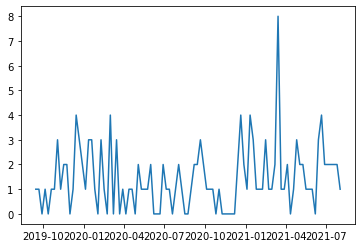

In [36]:
resampled_houston = houston_data_df.set_index("offense_or_input_date").resample("w")["case_id"].count()
plt.plot(resampled_houston)

In [37]:
sanantonio_data_df["offense_or_input_date"]

12889    20190907
12890    20190907
12895    20190909
12899    20190909
12908    20190911
           ...   
14863    20210618
14876    20210625
14892    20210630
14902    20210706
14913    20210714
Name: offense_or_input_date, Length: 138, dtype: int64

In [38]:
sanantonio_data_df["offense_or_input_date_cleaned"] = sanantonio_data_df["offense_or_input_date"].apply(
                    lambda x:  str(x)[4:6] # month
                                + "-"
                                + str(x)[6:8] # day
                                + "-" 
                                +str(x)[0:4]
    ).astype(
        "datetime64[ns]"
    )

# sanantonio_data_df["offense_or_input_date_cleaned"]


resampled_sanantonio = sanantonio_data_df.set_index(
    "offense_or_input_date_cleaned"
    ).resample(
        "w"
    )["case_id"].count(
    )


/var/folders/lw/9fwsvtm56_d6lkb4v5m8nyvm0000gn/T/ipykernel_60073/1272670971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sanantonio_data_df["offense_or_input_date_cleaned"] = sanantonio_data_df["offense_or_input_date"].apply(


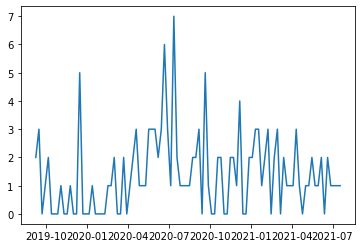

In [39]:
plt.plot(resampled_sanantonio)

In [40]:
resampled_austin_misdemeanor = austin_data_misdemeanor_df.set_index("offense_or_input_date").resample("w")["case_id"].count()
resampled_austin_misdemeanor.head()

offense_or_input_date
2019-10-06    1
2019-10-13    2
2019-10-20    0
2019-10-27    0
2019-11-03    0
Freq: W-SUN, Name: case_id, dtype: int64

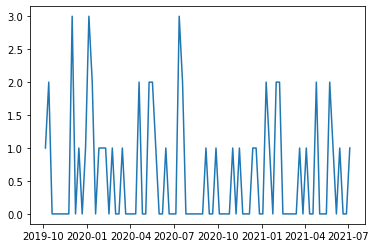

In [41]:
plt.plot(resampled_austin_misdemeanor)

In [42]:
resampled_austin_felony = austin_data_felony_df.set_index("offense_or_input_date").resample("w")["case_id"].count()
resampled_austin_felony.head()

offense_or_input_date
2019-10-06    1
2019-10-13    0
2019-10-20    0
2019-10-27    0
2019-11-03    0
Freq: W-SUN, Name: case_id, dtype: int64

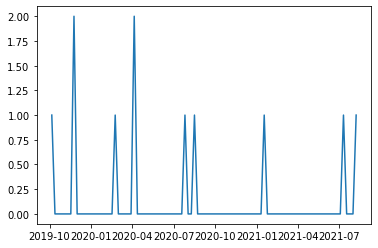

In [43]:
plt.plot(resampled_austin_felony)

In [44]:
resampled_dallas = dallas_data_df.set_index("offense_or_input_date").resample("w")["case_id"].count()
resampled_dallas.head()

offense_or_input_date
2019-10-13    1
2019-10-20    2
2019-10-27    2
2019-11-03    1
2019-11-10    1
Freq: W-SUN, Name: case_id, dtype: int64

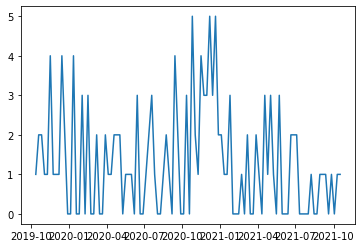

In [45]:
plt.plot(resampled_dallas)

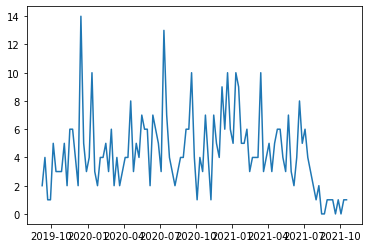

In [46]:
all_cases_tallies = pd.concat([
    resampled_houston.reset_index().rename(columns={"offense_or_input_date":"date"}),
    resampled_sanantonio.reset_index().rename(columns={"offense_or_input_date_cleaned":"date"}),
    resampled_austin_felony.reset_index().rename(columns={"offense_or_input_date":"date"}),
    resampled_austin_misdemeanor.reset_index().rename(columns={"offense_or_input_date":"date"}),
    resampled_dallas.reset_index().rename(columns={"offense_or_input_date":"date"}),
])

all_cases_tallies["date_dt"] = all_cases_tallies["date"].astype("datetime64[ns]")

texas_tallies = all_cases_tallies.set_index("date_dt").resample("w")["case_id"].sum()

plt.plot(texas_tallies)

### Felony analyses
- get total number of felonies per city
- get race and ethnicity of felons
- summarize address

In [47]:
houston_data_df["category_degree"].value_counts()

misdemeanor    115
felony          26
Name: category_degree, dtype: int64

In [48]:
dallas_data_df["category_degree"].value_counts()

misdemeanor    124
felony          14
Name: category_degree, dtype: int64

In [49]:
cat_columns = ["case_id", "Literal", "race", "sex",  "offense_or_input_date", "street_name"]


all_texas_felonies = pd.concat([
    dallas_data_df[dallas_data_df["category_degree"]=="felony"][cat_columns],
    houston_data_df[houston_data_df["category_degree"]=="felony"][cat_columns],
    sanantonio_data_df[sanantonio_data_df["Literal"] != "THEFT MAIL <=10 ADDRESSES"][cat_columns],
    austin_data_felony_df[cat_columns]
    
]).reset_index()

all_texas_felonies.head(20)

,index,case_id,Literal,race,sex,offense_or_input_date,street_name
0,1490,F2151288,THEFT-MAIL =10<30 ADDRESSES,White,Male,2021-01-10 00:00:00,NaN
1,7552,F2045216,THEFT-MAIL =10<30 ADDRESSES,White,Male,2020-02-16 00:00:00,NaN
2,16270,F2140642,THEFT-MAIL ID INFO =>50 ADDRESSES IAT,White,Male,2021-04-15 00:00:00,NaN
3,16668,F2045362,THEFT-MAIL =10<30 ADDRESSES,White,Female,2020-04-18 00:00:00,NaN
4,18094,F2154626,THEFT-MAIL =10<30 ADDRESSES,White,Male,2021-04-27 00:00:00,NaN
5,18240,F2054639,THEFT-MAIL =>30 ADDRESSES,Black,Female,2020-04-28 00:00:00,NaN
6,21951,F2040836N,THEFT-MAIL ID INFO <=10 ADDRESSES IAT,White,Female,2020-04-04 00:00:00,HOMELESS
7,42215,F1935083,THEFT-MAIL =>30 ADDRESSES,White,Male,2019-10-08 00:00:00,NaN
8,43368,F1935102,THEFT-MAIL =>30 ADDRESSES,Black,Male,2019-10-16 00:00:00,NaN
9,43369,F1935104,THEFT-MAIL =>30 ADDRESSES,Black,Male,2019-10-16 00:00:00,NaN


In [50]:
len(all_texas_felonies)

113

In [51]:
all_texas_felonies["race"].value_counts()

W                                 54
L                                 23
White                             10
B                                 10
White                              6
Black                              5
Black                              4
U                                  1
Name: race, dtype: int64

In [52]:
all_texas_felonies["street_name"].value_counts().head(20)

TRANSIENT    5
HOMELESS     2
Name: street_name, dtype: int64

In [53]:
#export only felonies
dallas_data_df[
    dallas_data_df["category_degree"]=="felony"
].reset_index(
).to_csv(
    "../output/felony_cases/dallas_felonies.csv", 
    index=False
)


houston_data_df[houston_data_df["category_degree"]=="felony"].reset_index(
).to_csv(
    "../output/felony_cases/houston_felonies.csv", 
    index=False
)


sanantonio_data_df[sanantonio_data_df["Literal"] != "THEFT MAIL <=10 ADDRESSES"].reset_index(
).to_csv(
    "../output/felony_cases/sanantonio_felonies.csv", 
    index=False
)

austin_data_felony_df.reset_index(
).to_csv(
    "../output/felony_cases/austin_felonies.csv", 
    index=False
)

In [54]:
all_texas_felonies.columns

Index(['index', 'case_id', 'Literal', 'race', 'sex', 'offense_or_input_date',
       'street_name'],
      dtype='object')

### Clean all values to make better summaries
- harmonize race categories
- harmonize 'TRANSIENT' and 'HOMELESS'

In [55]:
all_texas_felonies["race_cleaned"] = all_texas_felonies["race"].apply(
    lambda x: str(x).strip().replace("Black","B").replace("White", "W")
)

In [56]:
all_texas_felonies["street_name_cleaned"] = all_texas_felonies["street_name"].apply(
    lambda x: str(x).strip().replace("TRANSIENT", "HOMELESS")
)

In [57]:
address_summary = all_texas_felonies.groupby("street_name_cleaned").agg({
    "case_id": "count"
}).reset_index(
).sort_values(
    by="case_id" ,
    ascending=False
)

address_summary.head()

,street_name_cleaned,case_id
1,nan,106
0,HOMELESS,7


In [58]:
race_summary = all_texas_felonies.groupby("race_cleaned").agg({
    "case_id": "count"
}).reset_index()

race_summary["race_pct"] = (race_summary["case_id"]/ race_summary["case_id"].sum())

race_summary.head()

,race_cleaned,case_id,race_pct
0,B,19,0.168142
1,L,23,0.203540
2,U,1,0.008850
3,W,70,0.619469
